In [2]:
import os
import torch
import torchvision
from PIL import Image
from bs4 import BeautifulSoup
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


In [3]:
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target


In [4]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [5]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir("images/")))
#         self.labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("images/", file_image)
        label_path = os.path.join("annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [6]:
data_transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)


def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
train_size = int(len(dataset)*0.8 - (len(dataset)*0.8)%4)
test_size = len(dataset)-train_size

torch.manual_seed(0)
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, test_size])

train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=4, collate_fn=collate_fn)
val_data_loader = torch.utils.data.DataLoader(val_set, batch_size=4, collate_fn = collate_fn)


In [10]:
import random
def plot_image(img_tensor, annotation,index,path):
    img_tensor = img_tensor[index]
    annotation = annotation[index]
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    print(annotation)
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box.detach()

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
    plt.savefig(str(path)+'/'+str(index)+str(random.randint(1,1000)))
    plt.show()
    
def intersection_over_union(box_a, box_b):
    # print(box_a,box_b)
    # Determine the coordinates of each of the two boxes
    xA = max(box_a[0], box_b[0])
    yA = max(box_a[1], box_b[1])
    xB = min(box_a[2], box_b[2])
    yB = min(box_a[3], box_b[3])

    # Calculate the area of the intersection area
    area_of_intersection = (xB - xA + 1) * (yB - yA + 1)

    # Calculate the area of both rectangles
    box_a_area = (box_a[2]-box_a[0] + 1) * (box_a[3]-box_a[1] + 1)
    box_b_area = (box_b[2]-box_b[0] + 1) * (box_b[3]-box_b[1] + 1)
    # Calculate the area of intersection divided by the area of union
    # Area of union = sum both areas less the area of intersection
    iou = area_of_intersection / float(box_a_area + box_b_area - area_of_intersection)
    # Return the score
    # if iou < 0:
    #     print('warning')
    return iou

In [11]:
imgs = list(sorted(os.listdir("images/")))
labels = list(sorted(os.listdir("annotations/")))

model = get_model_instance_segmentation(3)
model.load_state_dict(torch.load('model.pt',map_location='cpu'))
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

0.8737431694601914	1.4440664156807697	1.7271704256707163	1.4922639417281043	{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


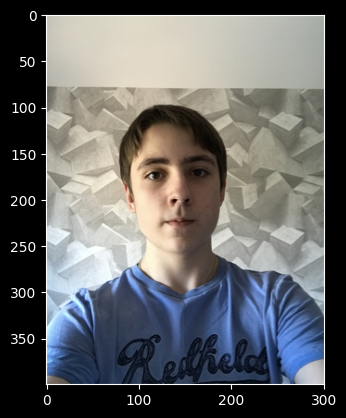

1.5835461132629993	{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


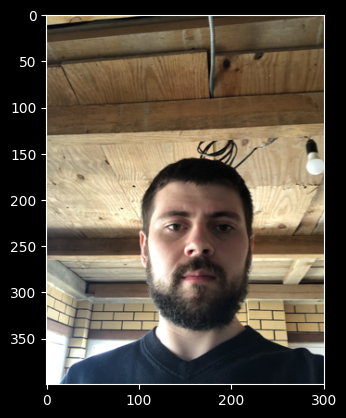

2.6345619839776924	2.392400420087515	{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


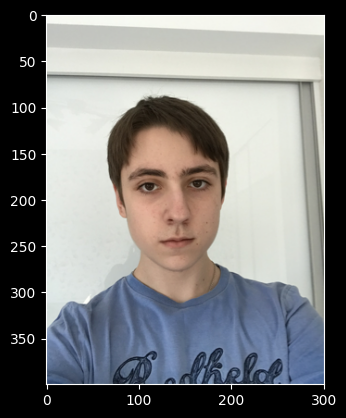

2.1377659538259643	2.191225225392367	2.049088099174907	{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


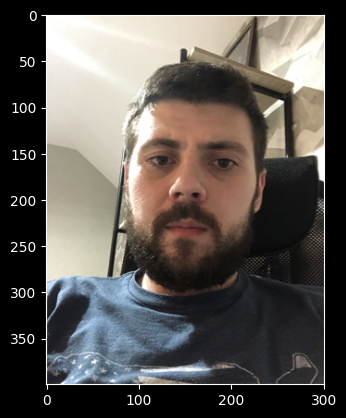

1.9219896640448086	1.820929837087317	2.6393013014879707	2.615848062223425	2.5253684640500142	2.4353680245472455	2.3408309755181405	{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


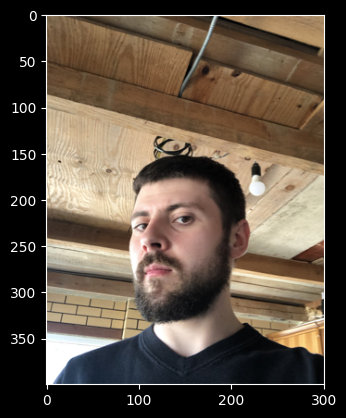

2.246959076716559	{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


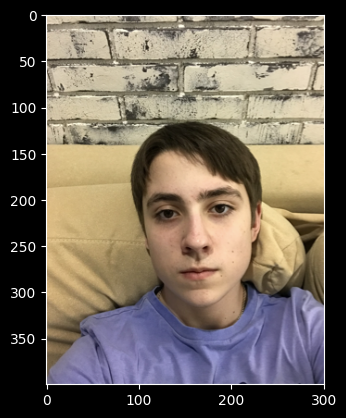

2.1660449608154404	2.097888187857307	2.025789123950878	1.9863699783511797	{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


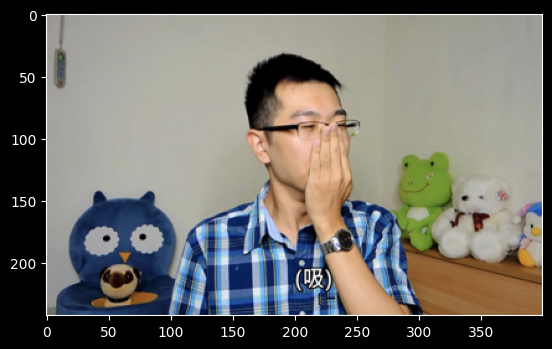

1.9442973211211467	2.1781381372280664	2.119323788526356	{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


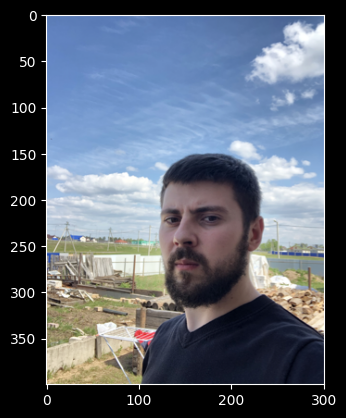

2.081282018283439	2.0861814317981615	2.164161220208801	2.2131540987654668	2.2066028066791796	{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


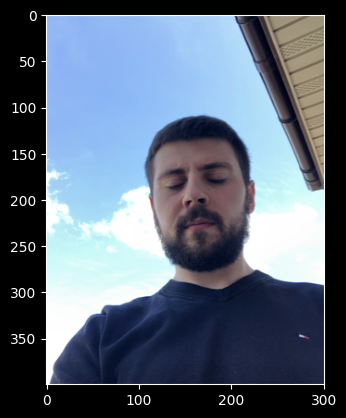

2.1662688774553995	2.2683428900006204	2.2194871212257357	2.894295350972141	{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


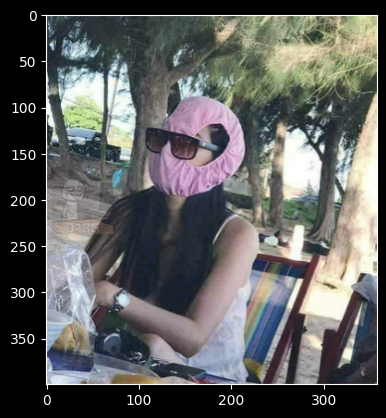

2.8265802345724214	2.7719615159217246	2.742591296038891	2.6950197038411203	2.653372961538898	2.606991901413133	2.5536635144460664	{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


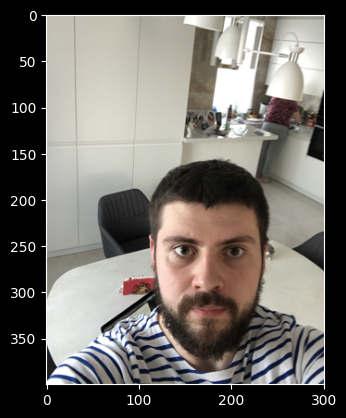

2.5056327694652096	2.507899115562139	2.498892784975693	

In [12]:
acc_list = []
score_list = []
for imgs, annotations in val_data_loader:
    # each patch
    imgs = list(img for img in imgs)
    annotations = [{k: v for k, v in t.items()} for t in annotations]
    pred = model(imgs)

    # xmin, ymin, xmax, ymax
    for i in range(len(imgs)):
        score_list.extend(pred[i]['scores'])
        if any(pred[i]['scores']) < 0.7:
            os.makedirs('val_result/wrong/'+str(i),exist_ok=True)
            plot_image(imgs,pred,i,'val_result/wrong/'+str(i))
        # each instance
        bbox = sorted(annotations[i]['boxes'].numpy(),key=lambda x: x[0])
        pred_bbox = sorted(pred[i]['boxes'].detach().numpy(),key=lambda x: x[0])
        iou = 0
        if len(bbox) == len(pred_bbox):
            for i in range(len(bbox)):
                iou += intersection_over_union(bbox[i],pred_bbox[i])
            acc_list.append(max(iou/len(bbox),0))
        else:
            count = 0
            for i in range(len(pred_bbox)):
                tmp_iou_list = []
                for j in range(len(bbox)):
                    tmp_iou_list.append(intersection_over_union(bbox[j],pred_bbox[i]))
                iou += max(tmp_iou_list)
                count += 1
            try:
                acc_list.append(max(iou/count,0))
            except:
                acc_list.append(max(iou/(count+1),0))
    #     print('-'*100)
    # print(acc_list,end='\t')
    print(sum(acc_list)/len(acc_list),end='\t')
# plot_image(imgs[4],pred[4])

In [ ]:
detach_list = []
for i in score_list:
    detach_list.append(float(i.detach().numpy()))
print(sum(detach_list)/len(detach_list))
print(sum(acc_list)/len(acc_list))

0.8522981903058305
2.498892784975693


{'boxes': tensor([[206.6431,  61.1230, 276.2622, 130.2893],
        [138.5556,  61.0689, 198.3069, 140.4578],
        [  1.4907,  39.4827,  53.1513, 138.7953],
        [ 78.4028,  79.2041, 125.8685, 132.0348],
        [ 70.0217,  82.2124,  90.5235, 113.2155]], grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1, 1, 1]), 'scores': tensor([0.9997, 0.9987, 0.9986, 0.8953, 0.0533], grad_fn=<IndexBackward0>)}


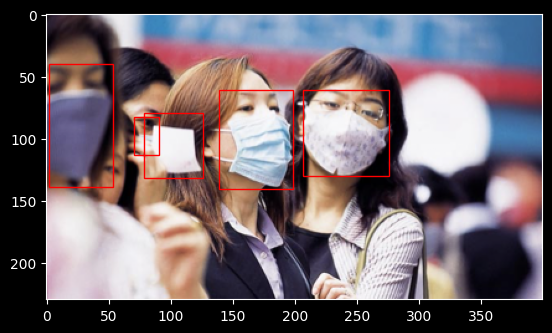

In [ ]:
plot_image(imgs,pred,0,'val_result')